## Imports

In [1]:
!pip install tensorflow

     |████████████████████████████████| 454.3 MB 8.7 kB/s  eta 0:00:01    |██████▎                         | 88.4 MB 80.7 MB/s eta 0:00:05     |██████████                      | 142.3 MB 89.0 MB/s eta 0:00:04
     |████████████████████████████████| 1.2 MB 48.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 43.9 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 55.9 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 129 kB 41.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 22.8 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 1.6 MB/s  eta 0:00:01
     |████████████████████████████████| 4.9 MB 39.5 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 41.7 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 44.3 MB/s eta 0:00:01
     |█████████████████████████████

In [2]:
%matplotlib inline
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta
import math
import sys
import boto3, sagemaker

## Load Data

In [3]:
#s3 = boto3.resource('s3')


#with open('X.pickle', 'wb') as data:
#    s3.Bucket("covid-ct-scan").download_fileobj("X.pickle", data)

with open('X.pickle', 'rb') as data:
    X = pickle.load(data)
    
#with open('y.pickle', 'wb') as data:
#    s3.Bucket("covid-ct-scan").download_fileobj("y.pickle", data)

with open('y.pickle', 'rb') as data:
    y = pickle.load(data)

## Explore and Visualize Data

In [5]:
X.shape, y.shape

((746, 350, 350, 1), (746, 1))

In [6]:
# Let's check the data types - TensorFlow requires float32 and/or int32
X.dtype, y.dtype

(dtype('float64'), dtype('int32'))

In [7]:
X = X.astype('float32')

In [8]:
# Confirming the data type
X.dtype

dtype('float32')

In [9]:
print("The Memory size of the data = {} KBs".format(int(sys.getsizeof(X))))

The Memory size of the data = 365540144 KBs


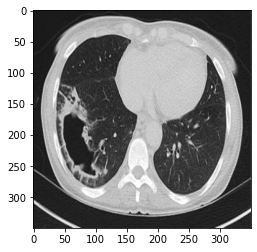

In [10]:
_ = plt.imshow(X[10].reshape(350, 350), cmap='gray')
plt.show()

## Data Dimensions

In [14]:
# We know that the images are 100 pixels by 100 pixels
img_size = 350

# Images are stored in one-dimensional arrays of this length
img_size_flat = img_size*img_size

# Height and width of each image in Tuple
img_shape = (img_size, img_size)

# Number of color channels for the image: 1 channel for gray-scale
num_channels = 1

# Number of classes - two classes, covid positive or covid negative
num_classes = 2

## Network Architecture

Input: images with 350 x 350 pixels grayscale
1. Layer: Conv1 -> ReLu -> MaxPool: [.,175,175,16] 
2. Layer: Conv2 -> ReLu -> MaxPool: [.,88,88,32]
3. Layer: FC -> ReLu: [.,1024]
4. Layer: FC -> ReLu: [.,2]

## Hyperparameters of Neural Network

In [15]:
# Convolutional layer 1
filter1_size = 3  #Convolution filters are 3 x 3 pixels
num_filters1 = 16 #There are 16 of these filters

# Convolutional layer 2
filter2_size = 3 #Convolution filters are 5 x 5 pixels
num_filters2 = 32 #There are 32 of these filters

# Pooling
window_size = 3 #Pooling window 2x2
window_stride = 2 #Move by 2 strides

# Fully-connected layer
fc_size=1024     # Number of nodes in the fully-connected layer

# Convolution stride
conv_stride=1

## Training and Test sets

In [16]:
X.shape, y.shape

((746, 350, 350, 1), (746, 1))

In [17]:
# Split the dataset into 70% (522 ea images) training and 30% (246 ea images) test sets
X_train = X[:523]
X_test = X[523:]
y_train = y[:523]
y_test = y[523:]

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((523, 350, 350, 1), (223, 350, 350, 1), (523, 1), (223, 1))

## Helper function for Creating Weights

In [19]:
def weights(shape):
    weights = tf.Variable(tf.random.normal(shape=shape, stddev=0.05))
    return weights

## ConvNet1

In [20]:
shape_1 = [filter1_size, filter1_size, num_channels, num_filters1]
shape_bias1 = [num_channels, img_size, img_size, num_filters1]
conv1_weights = weights(shape_1)
bias_1 = tf.Variable(tf.ones(shape=shape_bias1))

In [21]:
def ConvNet1(image):
    # Conv1 layer
    conv1 = tf.nn.conv2d(input=image, filters=conv1_weights, strides=conv_stride, padding='SAME')
    conv1+=bias_1
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(input=conv1, ksize=window_size, strides=window_stride, padding='SAME')
    return conv1

In [22]:
conv1 = ConvNet1(X_train)
conv1.shape

TensorShape([523, 175, 175, 16])

## ConvNet2

In [23]:
shape_2 = [filter2_size, filter2_size, num_filters1, num_filters2]
shape_bias2 = [num_channels, img_size//2, img_size//2, num_filters2]
conv2_weights = weights(shape_2)
bias_2 = tf.Variable(tf.ones(shape=shape_bias2))

In [24]:
def ConvNet2(conv1):
    # Conv2 Layer
    conv2 = tf.nn.conv2d(input=conv1, filters=conv2_weights, strides=conv_stride, padding='SAME')
    conv2+=bias_2
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(input=conv2, ksize=window_size, strides=window_stride, padding='SAME')
    return conv2

In [25]:
conv2 = ConvNet2(conv1)
conv2.shape

TensorShape([523, 88, 88, 32])

## Flatten Layer

In [26]:
def flatten_layer(conv2):
    layer_shape = conv2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    flat_layer = tf.reshape(conv2, [-1, num_features])
    return flat_layer, num_features

In [27]:
flat, features = flatten_layer(conv2)
features, flat.shape

(247808, TensorShape([523, 247808]))

## Fully Connected Layer

In [28]:
# Fully connected layer
num_features=247808 
fc_shape = [num_features, fc_size]
fc_weights = tf.Variable(tf.random.normal(shape=fc_shape))
bias_fc = tf.Variable(tf.ones([fc_size]))
# Output layer
shape_out = [fc_size, num_classes]
w_out = tf.Variable(tf.random.normal(shape=shape_out))
b_out = tf.Variable(tf.ones([num_classes]))

In [29]:
fc_weights.shape

TensorShape([247808, 1024])

In [30]:
def make_prediction(flat_layer, fc_weights, bias_fc, w_out, b_out):
    #Fully connected layer
    fc_product = tf.matmul(flat_layer, fc_weights)
    fully_connected = tf.keras.activations.relu(fc_product+bias_fc)
    fc_drop = tf.nn.dropout(fully_connected, rate=0.7, seed=1) # Drop 70% of the input elements randomly
    # Output layer
    output = tf.matmul(fc_drop, w_out)
    prediction = tf.keras.activations.softmax(output + b_out)
    return prediction

In [31]:
def model(image):
    conv1 = ConvNet1(image)
    conv2 = ConvNet2(conv1)
    flat_layer, num_features = flatten_layer(conv2)
    predictions = make_prediction(flat_layer, fc_weights, bias_fc, w_out, b_out)
    return predictions

## Compile and Train the Model

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [33]:
# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [34]:
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [35]:
# Package the data into batches
batch_size=16
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(1024).batch(batch_size)

In [36]:
import time

training_loss_values=[]
training_accuracy_values=[]
test_accuracy_values=[]

start = time.time()
epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))
    

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)
            

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, [fc_weights, bias_fc, w_out, b_out])

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, [fc_weights, bias_fc, w_out, b_out]))
        
        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)
        
        # Log every 1874 batches.
        if step%16 == 0 and step!=0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 32))
            
         # Display metrics at the end of every 1874 batch
        if step%16==0 and step!=0:
            train_acc = train_acc_metric.result()
            print("Training acc (for one batch): %.4f" % (float(train_acc),))

    # Run a test loop at the end of each epoch.
    for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
        predictions = model(x_batch_test)
        #Update test metrics
        test_acc_metric.update_state(y_batch_test, predictions)
        if step%8==0 and step!=0:
            test_acc = test_acc_metric.result()
            print("Test acc: %.4f" % (float(test_acc),))
    
    training_loss_values.append(float(loss_value))
    training_accuracy_values.append(float(train_acc_metric.result()))
    test_accuracy_values.append(float(test_acc_metric.result()))
    # Reset metrics at the end of each epoch
    train_acc_metric.reset_states()
    test_acc_metric.reset_states()
    
print("Time taken: %.2fs" % (time.time() - start))  


Start of epoch 1


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Training loss (for one batch) at step 16: 87259.9844
Seen so far: 544 samples
Training acc (for one batch): 0.4632
Training loss (for one batch) at step 32: 33947.3516
Seen so far: 1056 samples
Training acc (for one batch): 0.4818
Test acc: 0.4514

Start of epoch 2
Training loss (for one batch) at step 16: 21200.2676
Seen so far: 544 samples
Training acc (for one batch): 0.5000
Training loss (for one batch) at step 32: 2402.6304
Seen so far: 1056 samples
Training acc (for one batch): 0.4914
Test acc: 0.4653

Start of epoch 3
Training loss (for one batch) at step 16: 1.4173
Seen so far: 544 samples
Training acc (for one batch): 0.5147
Training loss (for one batch) at step 32: 0.6996
Seen so far: 1056 samples
Training acc (for one batch): 0.5277
Test acc: 0.4722

Start of epoch 4
Training loss (for one batch) at step 16: 0.6879
Seen so far: 544 samples
Training acc (for one batch): 0.5809
Training loss (for one batch) at step 32: 0.7014
Seen so far: 1056 samples
Training acc (for one bat

## Model Evaluation

In [37]:
# Loss
loss_fn(y_test, model(X_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.69752145>

In [38]:
# Calculate accuracy by hand
sum(tf.argmax(model(X_test), axis=1).numpy().reshape(-1,1)==y_test)/y_test.shape[0]

array([0.49775785])

In [39]:
# Calculate Precision
sum(y_test==0)/sum(tf.argmax(model(X_test), axis=1).numpy().reshape(-1,1)==0)

array([0.49775785])

In [40]:
# Calculate Recall
sum(tf.argmax(model(X_test), axis=1).numpy().reshape(-1,1)==0)/sum(y_test==0)

array([2.00900901])

In [41]:
len(training_loss_values), len(training_accuracy_values), len(test_accuracy_values)

(10, 10, 10)

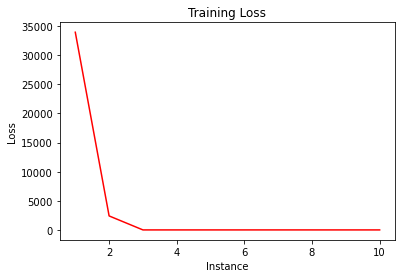

In [42]:
_ = plt.plot(range(1,len(training_loss_values)+1), np.array(training_loss_values), 'r')
_ = plt.xlabel("Instance")
_ = plt.ylabel("Loss")
_ = plt.title("Training Loss")
plt.show()

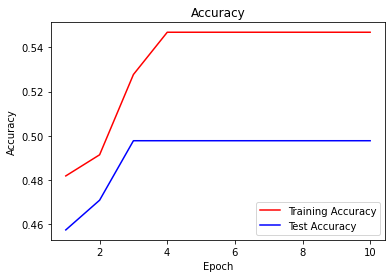

In [43]:
_ = plt.plot(range(1,len(training_accuracy_values)+1), np.array(training_accuracy_values), 'r', label='Training Accuracy')
_ = plt.plot(range(1,len(test_accuracy_values)+1), np.array(test_accuracy_values), 'b', label="Test Accuracy")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("Accuracy")
_ = plt.title("Accuracy")
_ = plt.legend(loc='best')
plt.show()